# Comparing the original TMD with MorphoPy

This notebook will show exemplarily that MorphoPy's implementation of https://github.com/BlueBrain/TMD gives identical results to the original.

The original software is written in Python2.7, thus, it cannot be integrated into this notebook. To reproduce the data used here run a TMD in a virtual environment:

```bash
virtualenv test_tmd
source ./test_tmd/bin/activate
git clone https://github.com/BlueBrain/TMD
pip install ./TMD
```
and convert the reconstructions found in `persistence_test/data/` to persistence diagrams run 

``` python2 .create_persistence_diagrams_using_tmd.py ```

Please note: 
If several soma points are present in a reconstruction, MorphoPy's default behavior is to collapse them all into their center of mass. This can lead to differences between the TMD original package, which represents soma points and neurites separately. If you want to remove the soma's influence on the computed feature please refer to the `get_neurites()` method.

In [3]:
import os
import sys
sys.path.append('..')
import neurontree.NeuronTree as nt
import pandas as pd
import numpy as np
import copy 

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# A selection of filter functions
def radial_distance(G, u, v):
    n = G.node[u]['pos']
    r = G.node[v]['pos']

    return np.sqrt(np.dot(n - r, n - r))

def height(G, u, v):
    n = G.node[u]['pos']
    r = G.node[v]['pos']
    return np.abs((n - r))[2]

def projection(G,u,v):
    
    r = G.node[u]['pos']
    p = G.node[v]['pos']
    n = np.array([0,1,0])
    return np.dot(r-p,n)

import networkx as nx

def path_length(G, u, v):
    return nx.shortest_path_length(G, v, u, weight='path_length')

def branch_order(G,u,v):
    
    if u == v:
        bo = 0
    else:
        path = nx.shortest_path(G, v, u)
        path.remove(u)
        bo = np.sum(np.array(list(nx.degree(G, path).values())) > 2)
    return bo

In [5]:
root, _ , files = list(os.walk("./data/"))

ValueError: not enough values to unpack (expected 3, got 0)

In [4]:
files = ['C010398B-P2.CNG.swc']
features = [radial_distance, path_length, projection, branch_order]

In [5]:
trees = []
for file in files:
    swc = pd.read_csv("./tmp/"+file,delim_whitespace=True, comment='#',
                              names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)
    
    N = nt.NeuronTree(swc, post_process=True)
    
    trees.append(N)

In [5]:
import copy
persistence_diagrams = []
for N in trees:
    
    #since TMD works without the soma only get neurites
    neurites = N.get_neurites(soma_included=False)
    
    p = dict()
    for feature in features:
        
        df = pd.DataFrame()
        for n in neurites: 
            df = df.append(n.get_persistence(f=feature))
        
        p[feature.__name__] = copy.copy(df)
    persistence_diagrams.append(p)

Text(0.5, 0.98, 'C010398B-P2.CNG.swc')

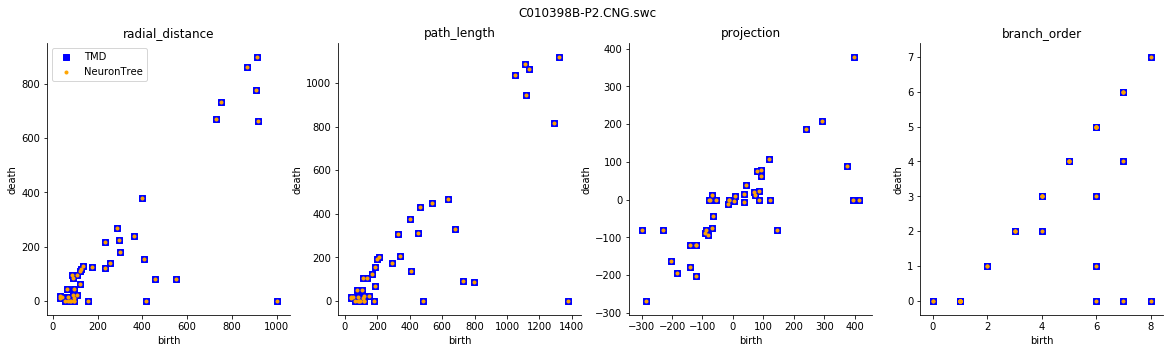

In [18]:
tmd_files = ['C010398B-P2_radial_distances.txt', 'C010398B-P2_path_distances.txt',
             'C010398B-P2_projection.txt', 'C010398B-P2_section_branch_orders.txt']

k = 0
plt.figure(figsize=(20,5))

for tmd_file in tmd_files:
    df = pd.read_csv("./tmp/persistence_test/" + tmd_file, header=None, sep=" ")

    f = features[k]
    A = df
    B = persistence_diagrams[0][f.__name__]

    plt.subplot(1,4,k+1)
    plt.scatter(np.round(A[0],2), np.round(A[1],2), marker='s', c='blue', label='TMD')

    plt.scatter(np.round(B['birth'],2),np.round(B['death'],2),marker='.', c='orange', label='NeuronTree')
    

    sns.despine()
    plt.title(f.__name__)
    plt.xlabel('birth')
    plt.ylabel('death')
    
    if k == 0:
        plt.legend()
    
    k +=1
plt.suptitle(files[0])


In [ ]:
# Create a minimal example 

In [21]:
test_graph = nx.DiGraph()

p=[[0,0,0], [0,1,0],[0,2,0], [0,3,0],[0,4,0], 
     [0,3.2,.5],[0,2.5,.5], [0,1.5,1],[0,2.5,1.3], 
     [0,1.5,2]]
t=[1,3,3,3,3,3,3,3,3,3]

node_data = []
k = 0
for i in range(1,11):
    node_data.append((i,dict(pos=np.array(p[k]), type=t[k], radius =0.5)))
    k += 1

test_graph.add_nodes_from(node_data)

edge_data = [(1,2), (2,3),(3,4),(4,5), (4,6), (3,7),(2,8), (8,9), (8,10)]
test_graph.add_edges_from(edge_data)

In [25]:
test_neuron = nt.NeuronTree(graph=test_graph)

Text(0.5, 1.0, 'test_neuron')

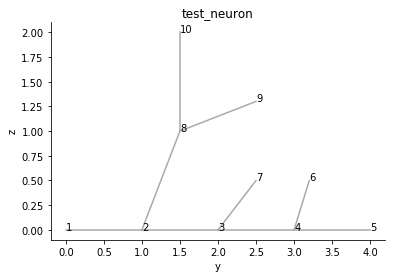

In [29]:
fig = plt.figure()
test_neuron.draw_2D(projection='yz', fig=fig)

for k, yz in enumerate(zip(np.array(p)[:,1],np.array(p)[:,2])):
    fig.gca().text(yz[0],yz[1], str(k+1))
sns.despine()
plt.xlabel('y')
plt.ylabel('z')
plt.title('test_neuron')

In [30]:
#rename neuron
test_neuron2 = copy.copy(test_neuron)

In [31]:
test_neuron2.rename_nodes({3:10, 10:3})

Text(0.5, 1.0, 'test_neuron_v2')

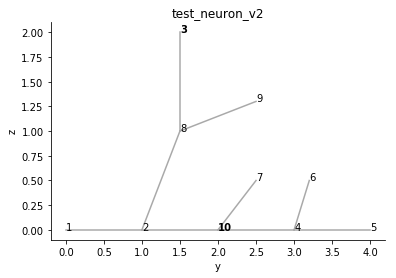

In [39]:
fig = plt.figure()
test_neuron2.draw_2D(projection='yz', fig=fig)
positions = nx.get_node_attributes(test_neuron2.get_graph(), 'pos')
for k, xyz in positions.items():
    if k == 3 or k == 10:
        fig.gca().text(xyz[1],xyz[2], str(k), weight='bold')
    else:
        fig.gca().text(xyz[1],xyz[2], str(k))
sns.despine()
plt.xlabel('y')
plt.ylabel('z')
plt.title('test_neuron_v2')

In [34]:
test_neurite = test_neuron.get_neurites(soma_included=False)[0]

No node is attributed as being the soma. Returning the node with no incoming edge.


In [35]:
test_neurite.get_persistence(f=projection)

No node is attributed as being the soma. Returning the node with no incoming edge.


,birth,death,node_id,node_type
0,2.2,2.0,6,3
1,0.5,0.5,10,3
2,1.5,1.0,7,3
3,1.5,0.0,8,3
4,3.0,0.0,2,1


In [26]:
test_neuron2.write_to_swc(path='./tmp/', file_name='test_neuron2')

In [38]:
df = pd.read_csv("./tmp/persistence_test/test_neuron_projection.txt", header=None, sep=" ")
df

,0,1
0,2.2,2.0
1,1.5,1.0
2,0.5,0.5
3,1.5,0.0
4,3.0,0.0


In [47]:
bo = test_neuron2.get_branch_order()

In [52]:
tips = test_neuron2.get_tips()
farthest_tip = tips[np.argmax([bo[t] for t in tips])]
k =1

path = nx.dijkstra_path(test_neuron2.get_graph(),1,farthest_tip)

In [5]:
def sort_nodes(self, start_idx=1):
    
    ordering = self.get_branch_order()
    tips = self.get_tips()
    r = self.get_root()
    k = start_idx
    active_tip = tips[np.argmax([ordering[t] for t in tips])]
    
    relabeling_dict = dict()
    
    while active_tip is not None:
        path = nx.dijkstra_path(test_neuron2.get_graph(),r,active_tip)
    
        
        # update k
        
        # get next active tip

In [38]:
def get_path_length(N):
    r = N.get_root()
    bo = N.get_branch_order()

    edges = N.edges(data=True)
    nodes = N.nodes()
    nodes.sort()
    edges.sort()       

    pl = dict(zip(nodes, [0]*len(nodes)))
    while edges:

        e1, e2, data = edges.pop(0)

        if e1 == r: 
            pl[e2] = data['path_length']
        elif pl[e1] != 0:
            pl[e2]  = pl[e1] + data['path_length']
        else:
            ix = np.random.randint(0,len(edges)) 
            edges.insert(ix,(e1,e2,data))

    return pl

def get_cumulative_path_length(N):
    tips = N.get_tips()
    G = N.get_graph()
    c_pl = dict(zip(N.nodes(), [0]*len(N.nodes())))

    active_nodes = list(tips)
    while len(active_nodes) > 0:
        a = active_nodes.pop(0)

        edges = G.edges(a, data=True)
        # for add pl of each edge coming from a
        for e1, e2, data in edges:
            c_pl[e1] += (c_pl[e2] + data['path_length'])

        # insert the parents
        parents = G.predecessors(a)
        active_nodes +=parents
    return c_pl

def get_barcode(N):
    r = N.get_root()
    G = N.get_graph()
    active_nodes = [r]

    index_order = []
    c_pl = get_cumulative_path_length(N)

    while len(active_nodes) > 0:

        a = active_nodes.pop(0)
        index_order += [a]
        successors = G.successors(a)
        d = [c_pl[s] for s in successors]
        if len(d)> 0:
            s_order = np.argsort(d)
            # insert the successors in order of their cumulative path length to the front
            active_nodes = list(np.array(successors)[s_order[::-1]]) + active_nodes
    
    N.rename_nodes(dict(zip(index_order,range(1,len(index_order)+1))))
    bct = np.array(nx.adj_matrix(N.get_graph()).T.sum(axis=0))[0]
    
    return bct



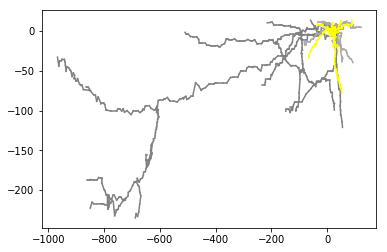

In [5]:
N.draw_2D()

In [42]:
neurites = N.get_neurites()

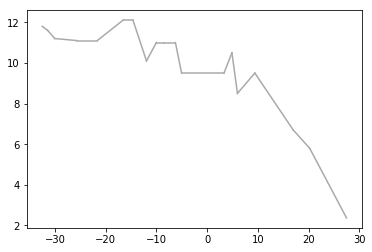

In [43]:
neurites[0].draw_2D()

In [119]:
bc = get_barcode(N)
bc

array([9, 1, 1, ..., 1, 1, 0])

In [115]:
bc=[1,1,1,3,1,1,0,1,1,0,1,1,2,1,0,1,1,1,1,0]

bc=[,1,3,1,0,1,0,1,0,1,0]

In [120]:
n = len(bc)
A_hat = np.zeros((n,n))
stack = []
index = None
# insert the first node as often as it has branches
for t in range(bc[0]):
    stack.insert(0,0)
for k in range(0,n):
    if index != None:
        A_hat[k,index] = 1
    index = k
    if bc[k] == 0:
        index = stack.pop(0)
    if bc[k] > 1:
        for t in range(bc[k]-1): #insert the branching point as often as it has subtrees
            stack.insert(0,k)

In [99]:
len(bc)

42

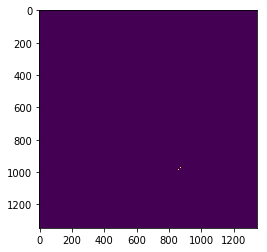

In [121]:
plt.imshow(A_hat, vmax=1, vmin=0)

In [15]:
A = nx.adjacency_matrix(N.get_graph())

In [20]:
A_hat.shape

(1345, 1345)

In [122]:
np.sum(A)

1344

In [123]:
np.sum(A_hat)

1344.0

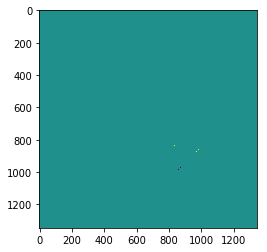

In [124]:
plt.imshow(A.todense()-A_hat)

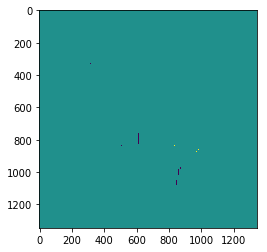

In [29]:
plt.imshow(A.todense()-A_hat)

In [ ]:
 % basic algorithm:
Set dA to square matrix of zeros
Use a stack
For i = 1:N
 if index exists then dA(i,index) = 1
  index = i
  If BCT(i) == ‘0|T’ then index = POP stack
  If BCT(i) == ‘2|B’ then PUSH i to stack
End